In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV

In [2]:
# Loading the Dataset
file_path = "merged_output.csv"     # Path to the dataset
data = pd.read_csv(file_path)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4987 entries, 0 to 4986
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       4987 non-null   int64 
 1   connection  4987 non-null   object
 2   timestamps  4987 non-null   object
 3   sizes       4987 non-null   object
 4   directions  4987 non-null   object
 5   file_name   4987 non-null   object
dtypes: int64(1), object(5)
memory usage: 233.9+ KB


In [4]:
data.shape                                              # num_flows, columns

(4987, 6)

### Preprocessing: convert string array to float

In [5]:
def get_float(str_array):
    # Remove brackets and split the string by commas
    cleaned_string = str_array.strip("[]")              # Remove [ and ]
    string_list = cleaned_string.split(",")             # Split by commas

    # Convert to a NumPy array of floats
    float_array = np.array(string_list, dtype=float)
    return float_array 

for field in ["sizes", "directions"]:
    print(field)
    data[field] = data[field].apply(lambda x: get_float(x))

sizes
directions


In [6]:
data.head()

,index,connection,timestamps,sizes,directions,file_name
0,1,"('10.184.62.19', 61599, '3.33.252.61', 443, 'T...","1727358570.247294,1727358570.321135,1727358570...","[66.0, 54.0, 307.0, 54.0, 54.0]","[0.0, 1.0, 0.0, 1.0, 0.0]",google_browsing.pcap
1,2,"('3.33.252.61', 443, '10.184.62.19', 61599, 'T...","1727358570.320960,1727358570.394823,1727358570...","[66.0, 54.0, 54.0]","[0.0, 0.0, 1.0]",google_browsing.pcap
2,3,"('10.184.62.19', 61532, '10.10.1.5', 53, 'UDP')",1727358570.998294,[75.0],[0.0],google_browsing.pcap
3,4,"('10.184.62.19', 51497, '10.10.1.5', 53, 'UDP')",1727358570.998542,[75.0],[0.0],google_browsing.pcap
4,5,"('10.10.1.5', 53, '10.184.62.19', 61532, 'UDP')",1727358571.000310,[91.0],[1.0],google_browsing.pcap


In [7]:
data.tail(5)

,index,connection,timestamps,sizes,directions,file_name
4982,4983,"('10.10.1.5', 53, '10.184.62.19', 55689, 'UDP')",1727359066.796789,[79.0],[1.0],teams_messaging.pcap
4983,4984,"('10.184.62.19', 64259, '20.190.175.152', 443,...","1727359066.797213,1727359066.827417,1727359066...","[66.0, 54.0, 590.0, 590.0, 590.0, 239.0, 590.0...","[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...",teams_messaging.pcap
4984,4985,"('20.190.175.152', 443, '10.184.62.19', 64259,...","1727359066.827288,1727359066.857509,1727359066...","[66.0, 54.0, 54.0, 153.0, 54.0, 590.0, 590.0, ...","[0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",teams_messaging.pcap
4985,4986,"('10.184.62.19', 55454, '10.10.1.5', 53, 'UDP')",1727359072.211430,[91.0],[0.0],teams_messaging.pcap
4986,4987,"('10.10.1.5', 53, '10.184.62.19', 55454, 'UDP')",1727359072.243714,[91.0],[1.0],teams_messaging.pcap


### Column description
- index       : row idx
- connection  : 5-tuple describing the conn. (source IP, source port, destination IP, destination port, protocol).
- timestamps  : A list of timestamps indicating when packets for the connection were captured.
- sizes       : A list of packet sizes (in bytes) for the connection.
- directions  : A list indicating packet directions (1 for outgoing, 0 for incoming).
- file_names  : The name of the PCAP file from which the data was extracted.

In [8]:
label_col = "label"
data[label_col] = data["file_name"].apply(lambda x: x.replace(".pcap", ""))                 # Extract label from the filename

In [9]:
print(data[label_col].value_counts())

label
google_browsing           2631
google_drive_upl-dw        530
streaming_spotify          466
google_mail                454
teams_messaging            380
teams_call                 276
streaming_amazon-prime     122
streaming_hotstar           47
streaming_netflix           46
streaming_youtube           35
Name: count, dtype: int64


In [11]:
# Dropping Classes with Less than 20 Instances
class_counts = data[label_col].value_counts()                                               # generate series of class_count
data = data[data[label_col].isin(class_counts[class_counts > 20].index)]

le = LabelEncoder()
data["label_encoded"] = le.fit_transform(data["label"])

In [12]:
# Hot encoding for labels
print(dict(zip(le.classes_, range(len(le.classes_)))))

{'google_browsing': 0, 'google_drive_upl-dw': 1, 'google_mail': 2, 'streaming_amazon-prime': 3, 'streaming_hotstar': 4, 'streaming_netflix': 5, 'streaming_spotify': 6, 'streaming_youtube': 7, 'teams_call': 8, 'teams_messaging': 9}


In [13]:
# Remove the file_name column (no more reqd.)
data = data.drop(columns=["file_name"])

In [14]:
print(data["sizes"].head(5))

# Check the data type of each entry in the 'sizes' column
print(data["sizes"].apply(type).value_counts())

direction_example = data.loc[1, "directions"]
print(direction_example)

print(len(direction_example))

0    [66.0, 54.0, 307.0, 54.0, 54.0]
1                 [66.0, 54.0, 54.0]
2                             [75.0]
3                             [75.0]
4                             [91.0]
Name: sizes, dtype: object
sizes
<class 'numpy.ndarray'>    4987
Name: count, dtype: int64
[0. 0. 1.]
3


In [15]:
def get_avg(x):
    return np.mean(x)

def get_std(x):
    return np.std(x)

def get_sum(x):
    return np.sum(x)

def get_duration(timestamps):
    ts_list = list(map(float, timestamps.split(',')))  # Convert string to list of floats
    return ts_list[-1] - ts_list[0] if len(ts_list) > 1 else 0

def get_total_packets(sizes):
    return len(sizes)

def get_IAT(timestamps):
    ts_list = list(map(float, timestamps.split(',')))  # Convert string to list of floats
    if len(ts_list) > 1:
        return np.diff(ts_list)
    return []           # No IAT for single packet


def get_mean_IAT(timestamps):
    iat = get_IAT(timestamps)
    return np.mean(iat)

def get_std_dev_IAT(timestamps):
    iat = get_IAT(timestamps)
    return np.std(iat)

In [16]:
# Packet-level: avg, std packet sizes
data["avg_pkt_size"] = data["sizes"].apply(get_avg)
data["stddev_pkt_size"] = data["sizes"].apply(get_std)
data["total_size"] = data["sizes"].apply(get_sum)



# Flow duration, total data, total pkts
data["flow_duration"] = data["timestamps"].apply(get_duration)
data["total_packets"] = data["sizes"].apply(get_total_packets)



# Intra-flow: mean and std of inter-arrival time or relative variance
data["mean_IAT"] = data["timestamps"].apply(get_mean_IAT)
data["stddev_IAT"] = data["timestamps"].apply(get_std_dev_IAT)

data.head(4)

c:\Users\manis\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\manis\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\manis\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\manis\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\manis\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret 

,index,connection,timestamps,sizes,directions,label,label_encoded,avg_pkt_size,stddev_pkt_size,total_size,flow_duration,total_packets,mean_IAT,stddev_IAT
0,1,"('10.184.62.19', 61599, '3.33.252.61', 443, 'T...","1727358570.247294,1727358570.321135,1727358570...","[66.0, 54.0, 307.0, 54.0, 54.0]","[0.0, 1.0, 0.0, 1.0, 0.0]",google_browsing,0,107.0,100.107942,535.0,0.147689,5,0.036922,0.036433
1,2,"('3.33.252.61', 443, '10.184.62.19', 61599, 'T...","1727358570.320960,1727358570.394823,1727358570...","[66.0, 54.0, 54.0]","[0.0, 0.0, 1.0]",google_browsing,0,58.0,5.656854,174.0,0.146736,3,0.073368,0.000495
2,3,"('10.184.62.19', 61532, '10.10.1.5', 53, 'UDP')",1727358570.998294,[75.0],[0.0],google_browsing,0,75.0,0.000000,75.0,0.000000,1,NaN,NaN
3,4,"('10.184.62.19', 51497, '10.10.1.5', 53, 'UDP')",1727358570.998542,[75.0],[0.0],google_browsing,0,75.0,0.000000,75.0,0.000000,1,NaN,NaN


In [ ]:
feature_cols = ["avg_pkt_size", "stddev_pkt_size", "total_size", "flow_duration", "total_packets", "mean_IAT", "stddev_IAT"]                 # Feature selection

# Drop values with no data
data_tmp = data.dropna()
features = data_tmp[feature_cols]
labels = data_tmp["label_encoded"]

print(data_tmp.shape)               # Total Data size after dropping NaN values
print(features.shape)               # Feature size after dropping NaN values

(3576, 14)
(3576, 6)


In [18]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [19]:
print("Overall data shape : ", data_tmp.shape)                       # Total data size after dropping NaN values
print("Feature vector     : ", features.shape)                       # Feature size after dropping NaN values

print("X_train shape      : ", X_train.shape)                        # Feature matrix for training data          2503 samples, with 6 features each                  0.3 test size
print("y_train shape      : ", y_train.shape)                        # Target vector for training data

print("X_test shape       : ", X_test.shape)                         # Feature matrix for testing data           1073 samples
print("y_test shape       : ", y_test.shape)                         # Actual labels for test data

Overall data shape :  (3576, 14)
Feature vector     :  (3576, 6)
X_train shape      :  (2503, 6)
y_train shape      :  (2503,)
X_test shape       :  (1073, 6)
y_test shape       :  (1073,)


***
# Simple Random Forest - 75%

In [26]:
# Simple Random Forest Classifier
rf = RandomForestClassifier(n_estimators=50, random_state=42)
rf.fit(X_train, y_train)

y_pred_simple = rf.predict(X_test)
print(classification_report(y_test, y_pred_simple, target_names=le.classes_))

                        precision    recall  f1-score   support

       google_browsing       0.84      0.92      0.88       722
   google_drive_upl-dw       0.46      0.51      0.49        96
           google_mail       0.56      0.33      0.41        83
streaming_amazon-prime       0.84      0.70      0.76        30
     streaming_hotstar       0.18      0.29      0.22         7
     streaming_netflix       0.40      0.20      0.27        10
     streaming_spotify       0.58      0.42      0.48        53
     streaming_youtube       0.00      0.00      0.00         5
            teams_call       0.69      0.34      0.46        32
       teams_messaging       0.33      0.20      0.25        35

              accuracy                           0.75      1073
             macro avg       0.49      0.39      0.42      1073
          weighted avg       0.74      0.75      0.74      1073



***
# RF with Grid Search - 76%

In [23]:
param_grid = {
    'n_estimators': [100, 200, 500],                                # Number of trees in the forest
    'max_depth': [10, 20, 30, None],                                # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],                                # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],                                  # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2']                                # Number of features to consider when looking for the best split
}

# Initalizing the Random Forest Classifier
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Performing Grid Search
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best Parameters
print("Best Parameters:", grid_search.best_params_)
print()

# Classification report
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}

                        precision    recall  f1-score   support

       google_browsing       0.82      0.94      0.88       722
   google_drive_upl-dw       0.45      0.44      0.44        96
           google_mail       0.57      0.33      0.42        83
streaming_amazon-prime       0.91      0.70      0.79        30
     streaming_hotstar       0.20      0.29      0.24         7
     streaming_netflix       0.40      0.20      0.27        10
     streaming_spotify       0.59      0.42      0.49        53
     streaming_youtube       0.33      0.40      0.36         5
            teams_call       0.75      0.28      0.41        32
       teams_messaging       0.50      0.26      0.34        35

              accuracy                           0.76      1073
             macro avg       0.55      0.42      0.46      1073
          weighted avg       0.74   

In [24]:
print("y_pred shape       : ", y_pred.shape)                         # Predicted labels for test data
print()
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

y_pred shape       :  (1073,)

Accuracy: 0.76


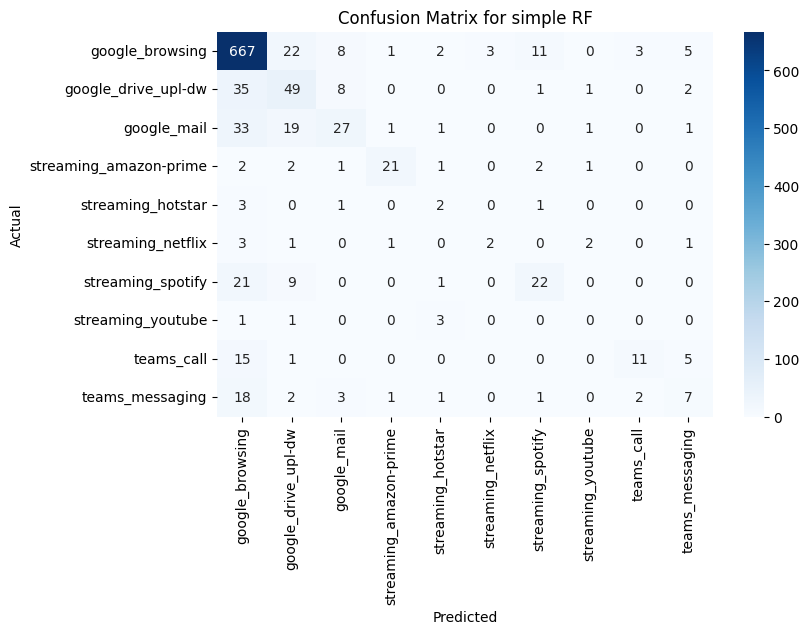

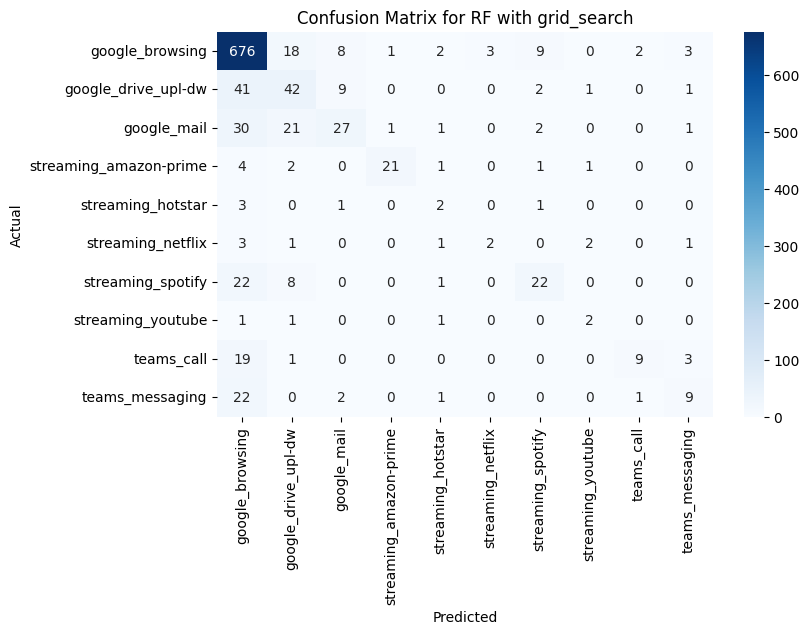

In [29]:
# Confusion Matrix plot for RF & RF=Grid Search
for y_pred in [y_pred_simple, y_pred]:
    model = "simple RF" if y_pred is y_pred_simple else "RF with grid_search"
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"Confusion Matrix for {model}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

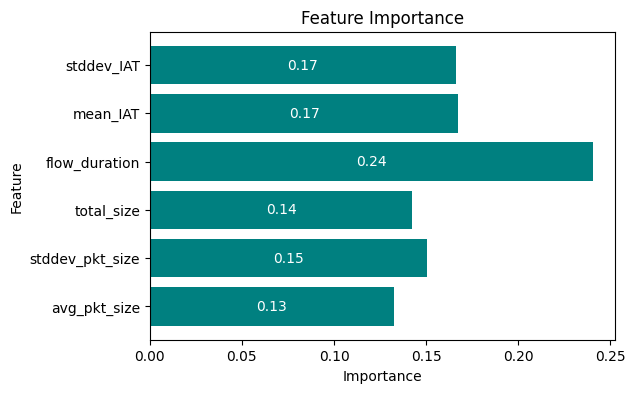

In [34]:
# Plot for Feature Importance
# importances = rf.feature_importances_
importances = best_model.feature_importances_
feature_names = features.columns

plt.figure(figsize=(6, 4))
bars = plt.barh(feature_names, importances, color='teal')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
for bar in bars:
    plt.text(bar.get_width() / 2,                               # X position (center of the bar)
             bar.get_y() + bar.get_height() / 2,                # Y position (center)
             f'{bar.get_width():.2f}',                          # Display importance value
             ha='center', va='center', fontsize=10, color='white')  
    
plt.show()

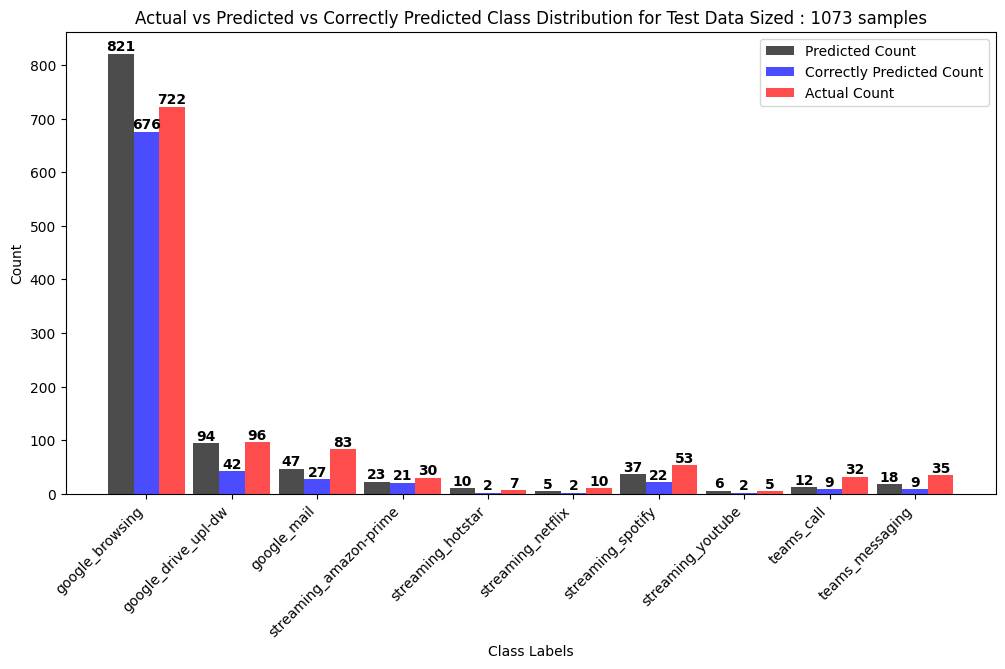

In [52]:
# Mapping encoded labels to class names
label_mapping = dict(zip(le.classes_, range(len(le.classes_))))

# Invert dictionary to get {0: 'google_browsing', 1: 'google_drive_upl-dw', ...}
label_mapping_inv = {v: k for k, v in label_mapping.items()}

# class distribution
unique_actual, counts_actual = np.unique(y_test, return_counts=True)    # Actual class distribution
unique_pred, counts_pred = np.unique(y_pred, return_counts=True)        # Predicted class distribution

# Convert numbers to class labels
actual_labels = [label_mapping_inv[i] for i in unique_actual]
predicted_labels = [label_mapping_inv[i] for i in unique_pred]

# Ensure all labels are present (even if missing in predictions)
all_labels = sorted(set(actual_labels) | set(predicted_labels), key=lambda x: label_mapping[x])

# Convert to dictionary for alignment
actual_counts_dict = dict(zip(actual_labels, counts_actual))
predicted_counts_dict = dict(zip(predicted_labels, counts_pred))

# Fill missing classes with zero count
actual_counts = [actual_counts_dict.get(label, 0) for label in all_labels]
predicted_counts = [predicted_counts_dict.get(label, 0) for label in all_labels]

# Count correctly predicted samples for each class (True Positives)
true_positives = {label: 0 for label in all_labels}  # Initialize all as 0

for actual, pred in zip(y_test, y_pred):
    if actual == pred:  # Correct prediction
        class_label = label_mapping_inv[actual]
        true_positives[class_label] += 1

# Convert true positives to a list for plotting
true_positive_counts = [true_positives.get(label, 0) for label in all_labels]

# Bar width and positions
x = np.arange(len(all_labels))  # Positions for bars
width = 0.3  # Width of bars

# Plot
plt.figure(figsize=(12,6))
bars1 = plt.bar(x - width, predicted_counts, width, label="Predicted Count", color="black", alpha=0.7)
bars2 = plt.bar(x, true_positive_counts, width, label="Correctly Predicted Count", color="blue", alpha=0.7)
bars3 = plt.bar(x + width, actual_counts, width, label="Actual Count", color="red", alpha=0.7)

# Add text labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height, f'{height}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Labels and Title
plt.xlabel('Class Labels')
plt.ylabel('Count')
plt.title(f'Actual vs Predicted vs Correctly Predicted Class Distribution for Test Data Sized : {len(y_test)} samples')
plt.xticks(ticks=x, labels=all_labels, rotation=45, ha='right')  # Rotate x-labels for better readability
plt.legend()
plt.show()

***
# XGBoost - 75%

In [38]:
from xgboost import XGBClassifier

In [ ]:
xgb = XGBClassifier(
    n_estimators=500,
    max_depth=30,
    learning_rate=0.05,
    random_state=42
)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print(classification_report(y_test, y_pred_xgb, target_names=le.classes_))

                        precision    recall  f1-score   support

       google_browsing       0.85      0.90      0.88       722
   google_drive_upl-dw       0.46      0.48      0.47        96
           google_mail       0.54      0.40      0.46        83
streaming_amazon-prime       0.77      0.67      0.71        30
     streaming_hotstar       0.33      0.29      0.31         7
     streaming_netflix       0.20      0.10      0.13        10
     streaming_spotify       0.60      0.60      0.60        53
     streaming_youtube       0.00      0.00      0.00         5
            teams_call       0.59      0.41      0.48        32
       teams_messaging       0.36      0.29      0.32        35

              accuracy                           0.75      1073
             macro avg       0.47      0.41      0.44      1073
          weighted avg       0.74      0.75      0.74      1073



***
# Stratified K-fold - 72%

In [41]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [43]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(best_model, X_train, y_train, cv=skf, scoring='accuracy')

print(f"Stratified K-Fold Accuracy: {scores.mean():.2f}")

Stratified K-Fold Accuracy: 0.72


---
# Testing

In [44]:
data_tmp["label"].value_counts()

label
google_browsing           2324
google_drive_upl-dw        333
google_mail                253
streaming_spotify          188
teams_messaging            146
streaming_amazon-prime     114
teams_call                 107
streaming_hotstar           46
streaming_netflix           34
streaming_youtube           31
Name: count, dtype: int64

In [45]:
data_tmp.shape

(3576, 14)